In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt


In [126]:
file_path1 = '/Volumes/Transcend/HackNtu_2017/Security/Raw Data/train.csv'
file_path2 = '/Volumes/Transcend/HackNtu_2017/Security/Raw Data/val.csv'
df_train = pd.read_csv(file_path1)
df_val = pd.read_csv(file_path2)
df_train.drop('device_hashed_mac', axis= 1,inplace = True)
df_val.drop('device_hashed_mac', axis= 1,inplace = True)

df_val = df_train.loc[df_train['event_flow_outbound_or_inbound'] == 'outbound' ]# For 判斷此為被攻擊的數據
df_val = df_val.loc[df_val['event_flow_outbound_or_inbound'] == 'outbound' ]
df_train.head()

,Unnamed: 0,Unnamed: 0.1,device_dev_name,device_family_name,device_os_name,device_type_name,device_vendor_name,event_protocol_id,event_flow_outbound_or_inbound,event_role_device_or_router,event_role_server_or_client,event_rule_category,event_rule_id,event_rule_name,event_rule_reference,event_rule_severity,event_self_ipv4,event_time,router_ip
0,172277,172277,0,0,0,0,0,6,outbound,device,server,0,1130489,SSL TLSv1.0 FREAK with CBC Cipher TLS_RSA_EXPO...,CVE-2015-0204; CVE-2015-1637,3,10.200.10.3,16,156.15.215.88
1,502376,502376,1,1,1,1,1,6,outbound,device,server,0,1130489,SSL TLSv1.0 FREAK with CBC Cipher TLS_RSA_EXPO...,CVE-2015-0204; CVE-2015-1637,3,192.168.1.25,10,21.227.231.223
2,795932,795932,2,0,2,0,2,6,outbound,device,server,0,1130489,SSL TLSv1.0 FREAK with CBC Cipher TLS_RSA_EXPO...,CVE-2015-0204; CVE-2015-1637,3,192.168.10.114,14,217.123.122.179
3,43035,43035,3,0,3,0,2,6,outbound,device,server,0,1130489,SSL TLSv1.0 FREAK with CBC Cipher TLS_RSA_EXPO...,CVE-2015-0204; CVE-2015-1637,3,192.168.1.102,14,114.176.251.173
4,616236,616236,2,0,2,0,2,6,outbound,device,server,0,1130491,SSL TLSv1.0 FREAK with CBC Cipher TLS_RSA_EXPO...,CVE-2015-0204; CVE-2015-1637,3,192.168.0.2,16,183.156.247.70


In [119]:
def groundtruth_for_xgb(groundtruth):
    # The function is for class is represented by a number and should be from 0 to num_class - 1. 
    output = groundtruth.tolist()
    min_ = min(output)
    output = np.array([ i- min_ for i in output])
    return output
#inpit feature
X_train = df_train.values[:,[i+2 for i in range(5)] +[-2]]
X_val = df_val.values[:,[i+2 for i in range(5)] +[-2]]
y_train = groundtruth_for_xgb(df_train.values[:,-4])
y_val = groundtruth_for_xgb(df_val.values[:,-4])


#df_columns = df_values.columns
df_columns = ["device_dev_name", "device_family_name", "device_os_name", "device_type_name", "device_vendor_name", "event_protocol_id",'event_time']
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', y_val.shape)


X_train shape is (320520, 6)
y_train shape is (320520,)
X_val shape is (80130, 6)
y_val shape is (80130,)


NameError: name 'test' is not defined

In [ ]:
#######
#xgb
#######
dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)

In [117]:
#############
# training 
#############
xgb_params = {
    'booster':'gbtree',
    'eta': 0.3,
    'max_depth': 15,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'num_class': 3 ,
    'eval_metric': 'merror',
    'silent': 1
}

'''
parameter
eta:
step size shrinkage used in update to prevents overfitting.
After each boosting step, we can directly get the weights of new features. 
and eta actually shrinks the feature weights to make the boosting process more conservative.
like regularization
'''

'''
Before running XGboost, 
we must set three types of parameters: 
1.general parameters # it relates to which booster we are using to do boosting, commonly tree or linear model
2.booster parameters 
3.task parameters. # it depends on taskt such as ranking task, regression task

'''
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval = 20)

num_boost_round = partial_model.best_iteration 
num_boost_round

[0]	val-merror:0.598964
Will train until val-merror hasn't improved in 20 rounds.
[20]	val-merror:0.59874
Stopping. Best iteration:
[3]	val-merror:0.537826



3

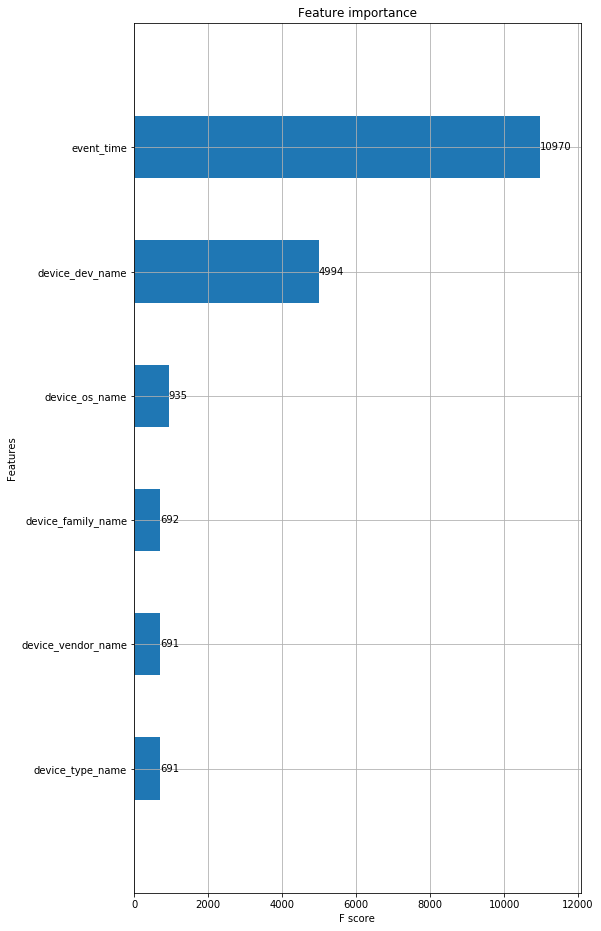

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, height=0.5, ax=ax,)
plt.show()

In [111]:
num_boost_round = partial_model.best_iteration
num_boost_round

0

In [104]:
# num_boost_round : Number of boosting iterations: 用validation error 得到的epoch
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round = num_boost_round)# Booster object
model

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, height=0.5, ax=ax)
plt.show()

ValueError: Booster.get_score() results in empty

In [112]:
##############
# prediction
##############
y_pred = model.predict(dval)
y_pred

array([[ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       ..., 
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334]], dtype=float32)

In [121]:
load_path = '/Volumes/Transcend/HackNtu_2017/Security/Model/0001.model'
bst = xgb.Booster({'nthread':4}) #init model
bst.load_model(load_path) # load data
bst

In [123]:
y_pred = bst.predict(dval)
y_pred

array([ 0.33333334,  0.33333334,  0.33333334, ...,  0.33333334,
        0.33333334,  0.33333334], dtype=float32)